In [1]:
## Adapted from the GAN implementation in the PyTorch-GAN model zoo:
## https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

In [2]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
%matplotlib inline

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
os.makedirs('images', exist_ok=True)

n_epochs = 200 #'number of epochs of training'
batch_size = 64 #'size of the batches'
lr = 0.0002 #'adam: learning rate'
b1 = 0.5 #'adam: decay of first order momentum of gradient'
b2 = 0.999 #'adam: decay of first order momentum of gradient'
n_cpu = 4 #'number of cpu threads to use during batch generation'
latent_dim = 100 #'dimensionality of the latent space'
img_size = 28 #'size of each image dimension'
channels = 1 #'number of image channels'
sample_interval=400 #'interval betwen image samples'

In [4]:
torch.cuda.is_available()

True

In [5]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [7]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs('../../data/mnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
## useful functions for collecting triangle statistics

def triplet_sample(X):
    """
    given an array of images X, return a triplet
    """
    while True:
        [i,j,k] = list(np.random.randint(0, X.shape[0], 3))
        if len({i,j,k}) == 3:
            return [X[i], X[j], X[k]]
        
        
def distance_L2(x,y):
    """
    given 2 images, x, y, return the normalized l2 distance between them,
    normalized so that the max distance is 1
    """
    return np.sqrt(np.sum((x - y)**2))/56


def distance_H(x,y):
    """
    given 2 images, x, y, return the normalized Hamming distance between them,
    """
    x_binary = np.asarray(x.reshape(784)>0)
    y_binary = np.asarray(y.reshape(784)>0) 
    return np.count_nonzero(x_binary != y_binary)/len(x_binary)


def triangle_distances_l2(x,y,z):
    """
    return the sorted l2 distances of the triangle formed by the points (x,y,z)
    """
    return sorted([distance_L2(x,y), distance_L2(x,z), distance_L2(y,z)])


def triangle_distances_H(x,y,z):
    """
    return the sorted normalized Hamming distances of the triangle formed by the points (x,y,z)
    """
    return sorted([distance_H(x,y), distance_H(x,z), distance_H(y,z)])


def angles(dxy, dxz, dyz):
    """
    Given the 3 distances of a triangle, return the sorted angles
    """
    theta_xy = np.arccos((-dxy**2 + dxz**2 + dyz**2)/(2*dxz*dyz))
    theta_xz = np.arccos((dxy**2 - dxz**2 + dyz**2)/(2*dxy*dyz))
    theta_yz = np.arccos((dxy**2 + dxz**2 - dyz**2)/(2*dxy*dxz))
    return sorted([theta_xy, theta_xz, theta_yz])


def triangle_distributions(X, Num):
    """
    Given an array of samples 4, generate two arrays of shape (Num, 2).
    
    Array 1: the 2 dimensions are [dmid-dmin, dmax-dmid] (l2 distance)
    Array 2: the 2 dimensions are [theta_min/theta_max, theta_min/theta_mid] (l2 distance)
    Array 3: the 2 dimensions are [dmid-dmin, dmax-dmid] (Hamming distance)
    Array 4: the 2 dimensions are [theta_min/theta_max, theta_min/theta_mid] (Hamming distance)
    """

    K_distances_l2 = np.zeros((Num,2))
    K_angles_l2 = np.zeros((Num,2))
    K_distances_H = np.zeros((Num,2))
    K_angles_H = np.zeros((Num,2))
    
    for i in range(Num):
        [x, y, z] = triplet_sample(X)
        
        ## l2 distances
        [d_min, d_mid, d_max] = triangle_distances_l2(x,y,z)
        [theta_min, theta_mid, theta_max] = angles(d_min, d_mid, d_max)        

        K_distances_l2[i,0] = d_mid - d_min
        K_distances_l2[i,1] = d_max - d_mid        
        K_angles_l2[i,0] = theta_min/theta_mid
        K_angles_l2[i,1] = theta_min/theta_max

        ## Hamming distances
        [d_min, d_mid, d_max] = triangle_distances_l2(x,y,z)
        [theta_min, theta_mid, theta_max] = angles(d_min, d_mid, d_max)        

        K_distances_H[i,0] = d_mid - d_min
        K_distances_H[i,1] = d_max - d_mid        
        K_angles_H[i,0] = theta_min/theta_mid
        K_angles_H[i,1] = theta_min/theta_max

        
    return [K_distances_l2, K_angles_l2, K_distances_H, K_angles_H]

### Training

In [9]:
g_loss_list = []
d_loss_list = []
g_overlap_list = []
d_overlap_list = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        optimizer_G.zero_grad()
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        # Generate a batch of images
        gen_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        # -----------------
        
        # ---------------------
        #  Train Discriminator
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        # ---------------------

        # ---------------------
        # Monitor Progress
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:# and batches_done != 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % \
                   (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
            
            batches_done_str = str(batches_done).zfill(8)
            
            ## save the losses
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            
            #----------------------
            # Generator Grad Overlap
            gen_imgs = generator(z)
 
            ## loss computed via built-in CE function
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            ## loss computed by scratch (needed to compute 2nd deriv)
            g_loss_homebrew = - torch.log(discriminator(gen_imgs)).mean()
            #print("g loss comparison: ", g_loss, g_loss_homebrew)
            
            ## this computes g_i, ||g||^2
            g_loss_grad = torch.autograd.grad(g_loss_homebrew, generator.parameters(), create_graph=True)
            g_loss_grad_norm_sq = 0
            for g in g_loss_grad:
                g_loss_grad_norm_sq = g_loss_grad_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H)_i, 4 ||H g||^2
            g_loss_grad2 = torch.autograd.grad(g_loss_grad_norm_sq, generator.parameters(), create_graph=True)
            g_loss_grad2_norm_sq = 0
            for g in g_loss_grad2:
                g_loss_grad2_norm_sq = g_loss_grad2_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H g)
            g_overlap_raw = 0
            for i in range(len(g_loss_grad2)):
                g_overlap_raw = g_overlap_raw + torch.mul(g_loss_grad[i], g_loss_grad2[i]).sum() 

            ## finally, compute the overlap (g^T H g)/(||g|| ||H g||)
            g_overlap = g_overlap_raw/torch.sqrt(g_loss_grad_norm_sq)/torch.sqrt(g_loss_grad2_norm_sq)
            g_overlap_list.append(g_overlap.data.cpu().numpy())
            #----------------------

            #----------------------
            # Discriminator Grad Overlap
            gen_imgs = generator(z)

            ## loss computed via built-in CE function
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            ## loss computed by scratch (needed to compute 2nd deriv)
            real_loss_homebrew = - torch.log(discriminator(real_imgs)).mean()
            fake_loss_homebrew = - torch.log(1.0-discriminator(gen_imgs.detach())).mean()
            d_loss_homebrew = (real_loss_homebrew + fake_loss_homebrew) / 2            
            #print("d loss comparison: ", d_loss, d_loss_homebrew)

            ## this computes g_i, ||g||^2
            d_loss_grad = torch.autograd.grad(g_loss_homebrew, discriminator.parameters(), create_graph=True)
            d_loss_grad_norm_sq = 0
            for g in d_loss_grad:
                d_loss_grad_norm_sq = d_loss_grad_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H)_i, 4 ||H g||^2
            d_loss_grad2 = torch.autograd.grad(d_loss_grad_norm_sq, discriminator.parameters(), create_graph=True)
            d_loss_grad2_norm_sq = 0
            for g in d_loss_grad2:
                d_loss_grad2_norm_sq = d_loss_grad2_norm_sq + g.pow(2).sum()

            ## this computes 2(g^T H g)
            d_overlap_raw = 0
            for i in range(len(d_loss_grad2)):
                d_overlap_raw = d_overlap_raw + torch.mul(d_loss_grad[i], d_loss_grad2[i]).sum() 

            ## finally, compute the overlap (g^T H g)/(||g|| ||H g||)
            d_overlap = d_overlap_raw/torch.sqrt(d_loss_grad_norm_sq)/torch.sqrt(d_loss_grad2_norm_sq)
            d_overlap_list.append(d_overlap.data.cpu().numpy())
            #----------------------

            ## print the overlaps
            print('g_overlap: %.3f, d_overlap: %.3f' % (g_overlap, d_overlap))

#             # plot a grid of samples
#             x = gen_imgs.data[:,0,:,:].cpu()
#             plt.figure(figsize=(6, 6))
#             plt.suptitle("Sampled Images, Batch_Num: " + str(batches_done), fontsize=16)
#             for j in range(64):
#                 plt.subplot(8, 8, j + 1)
#                 plt.imshow(x[j].reshape([28,28]), cmap='gray')
#                 plt.xticks(())
#                 plt.yticks(())
#             plt.savefig('images/sample_images_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()

#             Z = Variable(Tensor(np.random.normal(0, 1, (1000, latent_dim))))
#             gen_imgs = generator(Z)
#             X = gen_imgs.data[:,0,:,:].cpu().numpy()

#             [K_distances_l2, K_angles_l2, K_distances_H, K_angles_H] = triangle_distributions(X, 10000)
            
#             ## plot the 2d triangle distance density plot (l2 norm)
#             fig,ax = plt.subplots(1,1)
#             ax1 = sns.kdeplot(K_distances_l2[:,0], K_distances_l2[:,1])
#             ax1.set_xlim([0, 1.0])
#             ax1.set_ylim([0, 1.0])
#             ax1.set_xlabel(r"$d_{mid}-d_{min}$", fontsize=16)
#             ax1.set_ylabel(r"$d_{max}-d_{mid}$", fontsize=16)
#             ax1.set_title("Distance Density Plot (l2 distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/distance_plot_l2_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()
            
#             ## plot the 2d triangle angle density plot (l2 norm)
#             fig,ax = plt.subplots(1,1)
#             ax2 = sns.kdeplot(K_angles_l2[:,0], K_angles_l2[:,1])
#             ax2.set_xlim([0, 1.0])
#             ax2.set_ylim([0, 1.0])
#             ax2.set_xlabel(r"$\theta_{min}/\theta_{mid}$", fontsize=16)
#             ax2.set_ylabel(r"$\theta_{min}/\theta_{max}$", fontsize=16)
#             ax2.set_title("Angle Density Plot (l2 distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/triangle_plot_l2_' + batches_done_str + '.png')
#             plt.close()            
#             #plt.show()
    
#             ## plot the 2d triangle distance density plot (H norm)
#             fig,ax = plt.subplots(1,1)
#             ax1 = sns.kdeplot(K_distances_H[:,0], K_distances_H[:,1])
#             ax1.set_xlim([0, 1.0])
#             ax1.set_ylim([0, 1.0])
#             ax1.set_xlabel(r"$d_{mid}-d_{min}$", fontsize=16)
#             ax1.set_ylabel(r"$d_{max}-d_{mid}$", fontsize=16)
#             ax1.set_title("Distance Density Plot (H distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/distance_plot_H_' + batches_done_str + '.png')
#             plt.close()
#             #plt.show()
            
#             ## plot the 2d triangle angle density plot (H norm)
#             fig,ax = plt.subplots(1,1)
#             ax2 = sns.kdeplot(K_angles_H[:,0], K_angles_H[:,1])
#             ax2.set_xlim([0, 1.0])
#             ax2.set_ylim([0, 1.0])
#             ax2.set_xlabel(r"$\theta_{min}/\theta_{mid}$", fontsize=16)
#             ax2.set_ylabel(r"$\theta_{min}/\theta_{max}$", fontsize=16)
#             ax2.set_title("Angle Density Plot (H distance), Batch_Num: " + str(batches_done), fontsize=16)
#             plt.savefig('images/triangle_plot_H_' + batches_done_str + '.png')
#             plt.close()            
#             #plt.show()
        #torch.cuda.empty_cache()
        # ---------------------

[Epoch 0/200] [Batch 0/938] [D loss: 0.688701] [G loss: 0.677683]
g_overlap: 0.216, d_overlap: 0.773
[Epoch 0/200] [Batch 400/938] [D loss: 0.258009] [G loss: 1.609930]
g_overlap: 0.951, d_overlap: 0.990
[Epoch 0/200] [Batch 800/938] [D loss: 0.203303] [G loss: 1.816874]
g_overlap: 0.942, d_overlap: 0.996
[Epoch 1/200] [Batch 262/938] [D loss: 0.390825] [G loss: 3.704893]
g_overlap: 0.931, d_overlap: 0.991
[Epoch 1/200] [Batch 662/938] [D loss: 0.320707] [G loss: 1.870255]
g_overlap: 0.913, d_overlap: 0.997
[Epoch 2/200] [Batch 124/938] [D loss: 0.577738] [G loss: 3.304211]
g_overlap: 0.970, d_overlap: 0.999
[Epoch 2/200] [Batch 524/938] [D loss: 1.039650] [G loss: 5.272514]
g_overlap: 0.974, d_overlap: 1.000
[Epoch 2/200] [Batch 924/938] [D loss: 0.186921] [G loss: 1.705590]
g_overlap: 0.767, d_overlap: 0.987
[Epoch 3/200] [Batch 386/938] [D loss: 0.192280] [G loss: 1.663037]
g_overlap: 0.706, d_overlap: 0.987
[Epoch 3/200] [Batch 786/938] [D loss: 0.140529] [G loss: 2.960330]
g_overl

[Epoch 34/200] [Batch 108/938] [D loss: 0.301051] [G loss: 2.165290]
g_overlap: 0.569, d_overlap: 0.991
[Epoch 34/200] [Batch 508/938] [D loss: 0.407986] [G loss: 1.028710]
g_overlap: 0.404, d_overlap: 0.985
[Epoch 34/200] [Batch 908/938] [D loss: 0.276858] [G loss: 2.465076]
g_overlap: 0.503, d_overlap: 0.987
[Epoch 35/200] [Batch 370/938] [D loss: 0.396842] [G loss: 2.000546]
g_overlap: 0.464, d_overlap: 0.989
[Epoch 35/200] [Batch 770/938] [D loss: 0.503860] [G loss: 2.785042]
g_overlap: 0.786, d_overlap: 0.995
[Epoch 36/200] [Batch 232/938] [D loss: 0.349920] [G loss: 2.388284]
g_overlap: 0.642, d_overlap: 0.991
[Epoch 36/200] [Batch 632/938] [D loss: 0.338377] [G loss: 2.045944]
g_overlap: 0.666, d_overlap: 0.989
[Epoch 37/200] [Batch 94/938] [D loss: 0.445700] [G loss: 1.020635]
g_overlap: 0.518, d_overlap: 0.987
[Epoch 37/200] [Batch 494/938] [D loss: 0.420948] [G loss: 1.284298]
g_overlap: 0.653, d_overlap: 0.991
[Epoch 37/200] [Batch 894/938] [D loss: 0.384187] [G loss: 1.5507

[Epoch 67/200] [Batch 754/938] [D loss: 0.391158] [G loss: 1.199843]
g_overlap: 0.534, d_overlap: 0.981
[Epoch 68/200] [Batch 216/938] [D loss: 0.387396] [G loss: 1.795780]
g_overlap: 0.483, d_overlap: 0.983
[Epoch 68/200] [Batch 616/938] [D loss: 0.412170] [G loss: 1.638805]
g_overlap: 0.495, d_overlap: 0.980
[Epoch 69/200] [Batch 78/938] [D loss: 0.385454] [G loss: 1.668793]
g_overlap: 0.568, d_overlap: 0.978
[Epoch 69/200] [Batch 478/938] [D loss: 0.460256] [G loss: 1.951645]
g_overlap: 0.658, d_overlap: 0.990
[Epoch 69/200] [Batch 878/938] [D loss: 0.372828] [G loss: 1.350397]
g_overlap: 0.501, d_overlap: 0.977
[Epoch 70/200] [Batch 340/938] [D loss: 0.427908] [G loss: 1.095496]
g_overlap: 0.590, d_overlap: 0.982
[Epoch 70/200] [Batch 740/938] [D loss: 0.318863] [G loss: 1.892309]
g_overlap: 0.547, d_overlap: 0.980
[Epoch 71/200] [Batch 202/938] [D loss: 0.377150] [G loss: 1.300328]
g_overlap: 0.620, d_overlap: 0.983
[Epoch 71/200] [Batch 602/938] [D loss: 0.335961] [G loss: 1.3925

[Epoch 101/200] [Batch 462/938] [D loss: 0.435212] [G loss: 1.536953]
g_overlap: 0.414, d_overlap: 0.979
[Epoch 101/200] [Batch 862/938] [D loss: 0.394028] [G loss: 2.133150]
g_overlap: 0.774, d_overlap: 0.970
[Epoch 102/200] [Batch 324/938] [D loss: 0.390229] [G loss: 1.539506]
g_overlap: 0.615, d_overlap: 0.963
[Epoch 102/200] [Batch 724/938] [D loss: 0.282862] [G loss: 1.773213]
g_overlap: 0.074, d_overlap: 0.968
[Epoch 103/200] [Batch 186/938] [D loss: 0.380751] [G loss: 1.690520]
g_overlap: 0.325, d_overlap: 0.975
[Epoch 103/200] [Batch 586/938] [D loss: 0.379199] [G loss: 1.789472]
g_overlap: 0.565, d_overlap: 0.960
[Epoch 104/200] [Batch 48/938] [D loss: 0.449372] [G loss: 1.857889]
g_overlap: 0.593, d_overlap: 0.963
[Epoch 104/200] [Batch 448/938] [D loss: 0.517307] [G loss: 1.942997]
g_overlap: 0.671, d_overlap: 0.967
[Epoch 104/200] [Batch 848/938] [D loss: 0.349956] [G loss: 1.494830]
g_overlap: 0.516, d_overlap: 0.964
[Epoch 105/200] [Batch 310/938] [D loss: 0.438908] [G lo

[Epoch 135/200] [Batch 170/938] [D loss: 0.447023] [G loss: 1.267025]
g_overlap: 0.586, d_overlap: 0.955
[Epoch 135/200] [Batch 570/938] [D loss: 0.335465] [G loss: 1.860396]
g_overlap: 0.588, d_overlap: 0.951
[Epoch 136/200] [Batch 32/938] [D loss: 0.378256] [G loss: 1.913929]
g_overlap: 0.596, d_overlap: 0.967
[Epoch 136/200] [Batch 432/938] [D loss: 0.368296] [G loss: 1.717222]
g_overlap: 0.657, d_overlap: 0.960
[Epoch 136/200] [Batch 832/938] [D loss: 0.414494] [G loss: 1.936895]
g_overlap: 0.620, d_overlap: 0.940
[Epoch 137/200] [Batch 294/938] [D loss: 0.400214] [G loss: 1.786833]
g_overlap: 0.715, d_overlap: 0.951
[Epoch 137/200] [Batch 694/938] [D loss: 0.397614] [G loss: 1.622740]
g_overlap: 0.580, d_overlap: 0.944
[Epoch 138/200] [Batch 156/938] [D loss: 0.412416] [G loss: 1.596734]
g_overlap: 0.617, d_overlap: 0.958
[Epoch 138/200] [Batch 556/938] [D loss: 0.328048] [G loss: 1.584204]
g_overlap: 0.387, d_overlap: 0.969
[Epoch 139/200] [Batch 18/938] [D loss: 0.403134] [G los

[Epoch 168/200] [Batch 816/938] [D loss: 0.458938] [G loss: 1.190712]
g_overlap: 0.655, d_overlap: 0.964
[Epoch 169/200] [Batch 278/938] [D loss: 0.403495] [G loss: 1.376967]
g_overlap: 0.392, d_overlap: 0.969
[Epoch 169/200] [Batch 678/938] [D loss: 0.417382] [G loss: 1.701041]
g_overlap: 0.649, d_overlap: 0.950
[Epoch 170/200] [Batch 140/938] [D loss: 0.448443] [G loss: 1.455063]
g_overlap: 0.586, d_overlap: 0.963
[Epoch 170/200] [Batch 540/938] [D loss: 0.360299] [G loss: 1.488030]
g_overlap: 0.596, d_overlap: 0.958
[Epoch 171/200] [Batch 2/938] [D loss: 0.504446] [G loss: 1.243537]
g_overlap: 0.670, d_overlap: 0.952
[Epoch 171/200] [Batch 402/938] [D loss: 0.441988] [G loss: 1.651920]
g_overlap: 0.614, d_overlap: 0.944
[Epoch 171/200] [Batch 802/938] [D loss: 0.444387] [G loss: 1.376938]
g_overlap: 0.616, d_overlap: 0.952
[Epoch 172/200] [Batch 264/938] [D loss: 0.406249] [G loss: 1.563797]
g_overlap: 0.584, d_overlap: 0.964
[Epoch 172/200] [Batch 664/938] [D loss: 0.424963] [G los

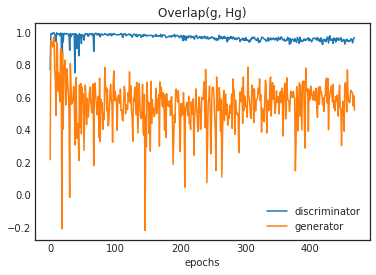

In [18]:
plt.plot(d_overlap_list, label='discriminator')
plt.plot(g_overlap_list, label='generator')
plt.title('Overlap(g, Hg)')
plt.xlabel('epochs')
plt.legend()
plt.show()